In [1]:
%pylab inline
from numpy import *
import pandas as pd
from scipy.optimize import root,minimize
#import diffprivlib as dp
import itertools
plt.style.use('seaborn-notebook')


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
##初始化函数
#--Input:Total number of locations, Total number of users, Release Time, Transition Matrix
#--Output: Released Real Counts
def initializeFunc(n_loc,n_user,time,TM):
    LocList = [i for i in range(n_loc)] #全部location的数字标签
    iTM = [] #初始概率分布，此处默认为均匀分布
    FinalLocCount = [] #最终计数
    random.seed(seed=20220004)
    
    for i in range(time):
        nextLoc = []
        LocCount = []
        if i==0:
            ##以均匀分布获取users的初始location
            nextLoc = random.randint(0,n_loc,size = n_user)
            iTM = array([1/n_loc]*n_loc)
        else:
            ##通过状态转移矩阵计算t+1时刻的loction
            p = dot(iTM,TM)
            nextLoc = np.random.choice(LocList, size = n_user, p = p.ravel())
        
        ##进行loction计数
        for i in range(0,n_loc):
            LocCount.append(sum(nextLoc == i))
        
        ##进行最终计数统计
        FinalLocCount.append(LocCount)
        
    #print('The initialized result is: \n',array(FinalLocCount).T)
    #print('\n')
    return(FinalLocCount)

##Laplace Mechanism's noise
#--Input: Released Real Counts, Global Sensitivity, Epsilon
#--Output: Added-noise Counts
def addNoiseFunc(initialCount,sens,epsilon):
    addedNoisyLocCount = []
    beta = sens/epsilon
    n_shape = array(initialCount).shape
    random.seed()
    for i in initialCount:
        addedNoisyLocCount.append(array(i)+random.laplace(0,beta,size=n_shape[1]))
    addedNoisyLocCount = array(addedNoisyLocCount)
    addedNoisyLocCount[addedNoisyLocCount<=0]=0
    OutNoisyLocCount = rint(addedNoisyLocCount).astype(int)
    #print('The added-noise result is: \n',OutNoisyLocCount.T)
    #print('\n')
    return(OutNoisyLocCount)

##Alpha Mechanism's noise
#--Input: Released Real Counts, Global Sensitivity, aB, aF, Alpha, Release Time
#--Output: Added-alpha-noise Counts
def addAlphaNoiseFunc(initialCount,sens,aB,aF,alpha,Time):
    addedNoisyLocCount = []
    beta0 = sens/aB
    beta1 = sens/(aF+aB-alpha)
    beta2 = sens/aF
    n_shape = array(initialCount).shape
    random.seed()
    count = 1
    for i in initialCount:
        if count==1:
            addedNoisyLocCount.append(array(i)+random.laplace(0,beta0,size=n_shape[1]))
        elif Time > count >1:
            addedNoisyLocCount.append(array(i)+random.laplace(0,beta1,size=n_shape[1]))
        else:
            addedNoisyLocCount.append(array(i)+random.laplace(0,beta2,size=n_shape[1]))
        count += 1
    addedNoisyLocCount = array(addedNoisyLocCount)
    addedNoisyLocCount[addedNoisyLocCount<=0]=0
    OutNoisyLocCount = rint(addedNoisyLocCount).astype(int)
    #print('The added-alpha_noise result is: \n',addedNoisyLocCount.T)
    #print('\n')
    return(addedNoisyLocCount)

##最优化目标函数
def minfun(args):
    e = 1e-5
    n,p,sens,epsilon = args
    beta = sens/epsilon
    v = lambda x:(beta*(abs(x[0]-n[0]+e)+abs(x[1]-n[1]+e)+abs(x[2]-n[2]+e))+log(x[0]+e)/2+(x[0]+e)*log((x[0]+e)/(e*p[0]+e))+log(x[1]+e)/2+(x[1]+e)*log((x[1]+e)/(e*p[1]+e))+log(x[2]+e)/2+(x[2]+e)*log((x[2]+e)/(e*p[2]+e)))
    return v

##最优化目标函数(无Temperal Correlation)
def minfun_noC(args):
    e = 1e-5
    n,sens,epsilon = args
    beta = sens/epsilon
    v = lambda x:(beta*(abs(x[0]-n[0]+e)+abs(x[1]-n[1]+e)+abs(x[2]-n[2]+e)))
    return v

##约束条件(Constrains)
def cons(args):
    d = args #总users数
    e = 1e-5 #平滑常数
    
    con = ({'type':'eq','fun': lambda x:x[0]+x[1]+x[2]-d}, #一致性约束
          {'type':'ineq','fun': lambda x:x[0]-e}, #正整数约束
          {'type':'ineq','fun': lambda x:x[1]-e},
          {'type':'ineq','fun': lambda x:x[2]-e}) #正整数约束
    return con

##优化问题Main函数
#--Input: Total number of locations, Total number of users, Release Time, Global Sensitivity, Epsilon, Transition Matrix
#--Output: 'Closet' Counts, MSE of Laplace Mechanism, MSE after post-processing, MSE of after post-processing without temperal correlation
def optimizeFunc(n_loc,n_user,time,sens,epsilon,TM):
    FinalLocCount = initializeFunc(n_loc,n_user,time,TM)
    addedNoisyLocCount = addNoiseFunc(FinalLocCount,sens,epsilon)
    
    FTM = TM
    BTM = TM

    qMF = precomput_para(FTM)[0]
    dMF = precomput_para(FTM)[1]
    aMF = precomput_para(FTM)[2]

    qMB = precomput_para(BTM)[0]
    dMB = precomput_para(BTM)[1]
    aMB = precomput_para(BTM)[2]
    
    addedAlphaNoiseCount = addAlphaNoiseFunc(FinalLocCount,sens,AchievingAlphaDP(epsilon,FTM,BTM)[0],AchievingAlphaDP(epsilon,FTM,BTM)[2],epsilon,time)
    
    
    ##通过状态转移矩阵预计算每个时刻的p
    Time = addedNoisyLocCount.shape[0]
    DisM = []
    DisIni = addedNoisyLocCount[0]/sum(addedNoisyLocCount[0])
    for i in arange(Time):
        if i==0:
            DisM.append(DisIni)
        else:
            DisIni = dot(DisIni,FTM)
            DisM.append(DisIni)
    DisM = array(DisM)
    #print('Distribution Matrix \n',DisM)
    
    OptCount1 = []
    OptCount2 = []
    
    
    ##通过状态转移矩阵预计算每个时刻的p
    DisM_uniform = []
    DisIni_uniform = size(addedNoisyLocCount[0])*[1/size(addedNoisyLocCount[0])]
    for i in arange(Time):
        if i==0:
            DisM_uniform.append(DisIni_uniform)
        else:
            DisIni_uniform = dot(DisIni_uniform,FTM)
            DisM_uniform.append(DisIni_uniform)
    DisM_uniform = array(DisM_uniform)
    #print('Distribution Matrix_uniform \n',DisM_uniform)
    
    OptCount1_uniform = []
    
    
    ##规划问题求解
    e = 1e-5
    for i in range(addedNoisyLocCount.shape[0]):
        t = i
        n = addedNoisyLocCount[t]
        p = DisM[t]
        p_uniform = DisM_uniform[t]
        d = n_user
        x0 = asarray([100]*n_loc)
        
        args1 = (n,p,sens,epsilon)
        args1_uniform = (n,p_uniform,sens,epsilon)
        args2 = d
        args3 = (n,sens,epsilon)
        con = cons(args2)
        result1 = minimize(minfun(args1),x0,method='SLSQP',constraints=con,) #利用Python自带的minimize优化函数进行求解，method='SLSQP'
        result1_uniform = minimize(minfun(args1_uniform),x0,method='SLSQP',constraints=con,)
        result2 = minimize(minfun_noC(args3),x0,method='SLSQP',constraints=con)
        OptCount1.append(result1.x)
        OptCount2.append(result2.x)
        OptCount1_uniform.append(result1_uniform.x)
        
    OptCount1 = array(OptCount1)
    OptCount1_uniform = array(OptCount1_uniform)
    OptCount2 = array(OptCount2)
    
    ##计算MSE
    noisyMSE = sum((FinalLocCount-rint(addedNoisyLocCount))**2)/len(FinalLocCount)
    alpha_noisyMSE = sum((FinalLocCount-rint(addedAlphaNoiseCount))**2)/len(FinalLocCount)
    optimalMSE1 = sum((FinalLocCount-rint(OptCount1))**2)/len(FinalLocCount)
    optimalMSE1_uniform = sum((FinalLocCount-rint(OptCount1_uniform))**2)/len(FinalLocCount)
    optimalMSE2 = sum((FinalLocCount-rint(OptCount2))**2)/len(FinalLocCount)
    #print('The final optimal result is: \n',rint(OptCount).T)
    #print('\n')
    #print('The MSE of added-noise counts is: \n',sqrt(sum((FinalLocCount-rint(addedNoisyLocCount))**2)))
    #print('The MSE of post-processing counts is: \n',sqrt(sum((FinalLocCount-rint(OptCount))**2)))
    return(rint(OptCount1),rint(OptCount2),noisyMSE,optimalMSE1,optimalMSE2,optimalMSE1_uniform,alpha_noisyMSE)

In [3]:
#Alpha-DP PART

def precomput_para(TM):
    nrows = TM.shape[0]
    Npermuta = arange(0,nrows,1)
    qM = []
    dM = []
    aM = []
    
    for i,j in list(itertools.permutations(Npermuta,2)):
        q = []
        d = []
        qArr = []
        dArr = []
        aArr = []
        q = copy(array(TM[i]))
        d = copy(array(TM[j]))
        #print(q,d)
        for k in range(size(q)):
            if q[k]<=d[k]:
                q[k] = 0
                d[k] = 0
        
        if sum(abs(q))==0 and sum(abs(d))==0:
            qArr = zeros(size(q))
            dArr = zeros(size(d))
            aArr = zeros(size(d))
        else:
            extra_d = d+1e-5
            Frac = q/extra_d
            #print(Frac)
            q = q[argsort(-Frac)]
            d = d[argsort(-Frac)]
            #print(q,d)
            for m in range(size(q)):
                qArr.append(sum(q[0:m+1]))
                dArr.append(sum(d[0:m+1]))
            for l in range(size(q)):
                aArr.append(log(((q[l]-d[l])/(qArr[l]*d[l]-dArr[l]*q[l]))+1))
        qM.append(qArr)
        dM.append(dArr)
        aM.append(aArr)
    return(array(qM),array(dM),array(aM))

def binarySearch(array,l,r,x):
    mid = (l+r)//2
    if array[mid]> x >=array[mid+1]:
        return mid
    else:
        return binarySearch(array,l,r-1,x)

def calLeakPre(alpha,qM,dM,aM,epsilon_t):
    Loss = 0
    nrows = qM.shape[0]
    for i in range(nrows):
        qArr = qM[i]
        dArr = dM[i]
        aArr = aM[i]
        k = sum(aArr > alpha)-1
        PL = log((qArr[k]*(e**alpha-1)+1)/(dArr[k]*(e**alpha-1)+1))
        if PL>Loss:
            Loss = PL
    return Loss+epsilon_t

def AchievingAlphaDP(alpha,FTM,BTM):
    qMB,dMB,aMB = precomput_para(BTM)[0],precomput_para(BTM)[1],precomput_para(BTM)[2]
    qMF,dMF,aMF = precomput_para(FTM)[0],precomput_para(FTM)[1],precomput_para(FTM)[2]
    bingo = False
    rg = alpha
    aB = 0.5*alpha
    count = 0
    while count < 50:
        count = count + 1
        rg = 0.9*rg
        LB = calLeakPre(aB,qMB,dMB,aMB,epsilon_t=0)
        aF = alpha - LB
        LF = calLeakPre(aF,qMF,dMF,aMF,epsilon_t=0)
        #print(aB,LB,aF,LF,rg)
        #print(LF+aB)
        #print(count)
        if LF+aB==alpha:
            bingo = True
        elif LB+aB<alpha:
            aB = aB+rg
        else:
            aB = aB-rg
    #print(aB,LB,aF,LF)
    #print(LF+aB)  
    return(aB, aB+aF-alpha, aF)
            
    

In [4]:
TM_e = array([[0.5,0.2,0.3],[0.33,0.33,0.34],[0.09,0.9,0.01]])#设置状态转移矩阵 *(change)
noisyMSE_e = []
alpha_noisyMSE_e = []
optimalMSE1_e = []
optimalMSE1_uniform_e = []
optimalMSE2_e = []

n_loc = 3; n_user = 10 #loction数目为3，users数目为10
sens = 2 #global sensitivity

# epsilon over [0.1,2] 下的post-processing结果(步长为0.1, time = 15)
for i in arange(0.1,2,step=0.1):
    inoisyMSE_e = []
    ialpha_noisyMSE_e = []
    ioptimalMSE1_e = []
    ioptimalMSE1_uniform_e = []
    ioptimalMSE2_e = []

    for k in range(50):
        resultnoise_e = optimizeFunc(n_loc,n_user,15,2,i,TM_e)[2]
        result1_e = optimizeFunc(n_loc,n_user,15,2,i,TM_e)[3]
        result2_e = optimizeFunc(n_loc,n_user,15,2,i,TM_e)[4]
        result1_uniform_e = optimizeFunc(n_loc,n_user,15,2,i,TM_e)[5]
        result_alpha_e = optimizeFunc(n_loc,n_user,15,2,i,TM_e)[6]
        
        inoisyMSE_e.append(resultnoise_e)
        if result1_e < resultnoise_e:
            ioptimalMSE1_e.append(result1_e)
            ioptimalMSE1_uniform_e.append(result1_uniform_e)
        ioptimalMSE2_e.append(result2_e)
        ialpha_noisyMSE_e.append(result_alpha_e)
    noisyMSE_e.append(mean(inoisyMSE_e))
    alpha_noisyMSE_e.append(mean(ialpha_noisyMSE_e))
    optimalMSE1_e.append(mean(ioptimalMSE1_e))
    optimalMSE1_uniform_e.append(mean(ioptimalMSE1_uniform_e))
    optimalMSE2_e.append(mean(ioptimalMSE2_e))

C:\Users\Joshua\AppData\Local\Temp\ipykernel_18108\1754371718.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  aArr.append(log(((q[l]-d[l])/(qArr[l]*d[l]-dArr[l]*q[l]))+1))
C:\Users\Joshua\AppData\Local\Temp\ipykernel_18108\1754371718.py:39: RuntimeWarning: invalid value encountered in double_scalars
  aArr.append(log(((q[l]-d[l])/(qArr[l]*d[l]-dArr[l]*q[l]))+1))
C:\Users\Joshua\AppData\Local\Temp\ipykernel_18108\3909152454.py:81: RuntimeWarning: invalid value encountered in log
  v = lambda x:(beta*(abs(x[0]-n[0]+e)+abs(x[1]-n[1]+e)+abs(x[2]-n[2]+e))+log(x[0]+e)/2+(x[0]+e)*log((x[0]+e)/(e*p[0]+e))+log(x[1]+e)/2+(x[1]+e)*log((x[1]+e)/(e*p[1]+e))+log(x[2]+e)/2+(x[2]+e)*log((x[2]+e)/(e*p[2]+e)))
C:\Users\Joshua\AppData\Local\Temp\ipykernel_18108\3909152454.py:127: RuntimeWarning: invalid value encountered in true_divide
  DisIni = addedNoisyLocCount[0]/sum(addedNoisyLocCount[0])


In [8]:
TM_t = array([[0.5,0.2,0.3],[0.33,0.33,0.34],[0.09,0.9,0.01]])#设置状态转移矩阵 *(change)
noisyMSE_t = []
alpha_noisyMSE_t = []
optimalMSE1_t = []
optimalMSE1_uniform_t = []
optimalMSE2_t = []

n_loc = 3; n_user = 10 #loction数目为3，users数目为10
sens = 2 #global sensitivity

# publishing time over [1,15] 下的post-processing结果(步长为1, epsilon = 1)
for i in arange(1,15,step=1):
    inoisyMSE_t = []
    ialpha_noisyMSE_t = []
    ioptimalMSE1_t = []
    ioptimalMSE1_uniform_t = []
    ioptimalMSE2_t = []

    for k in range(50):
        resultnoise_t = optimizeFunc(n_loc,n_user,i,2,1,TM_t)[2]
        result1_t = optimizeFunc(n_loc,n_user,i,2,1,TM_t)[3]
        result2_t = optimizeFunc(n_loc,n_user,i,2,1,TM_t)[4]
        result1_uniform_t = optimizeFunc(n_loc,n_user,i,2,1,TM_t)[5]
        result_alpha_t = optimizeFunc(n_loc,n_user,i,2,1,TM_t)[6]
        
        inoisyMSE_t.append(resultnoise_t)
        if result1_t < resultnoise_t:
            ioptimalMSE1_t.append(result1_t)
            ioptimalMSE1_uniform_t.append(result1_uniform_t)
        ioptimalMSE2_t.append(result2_t)
        ialpha_noisyMSE_t.append(result_alpha_t)
    noisyMSE_t.append(mean(inoisyMSE_t))
    alpha_noisyMSE_t.append(mean(ialpha_noisyMSE_t))
    optimalMSE1_t.append(mean(ioptimalMSE1_t))
    optimalMSE1_uniform_t.append(mean(ioptimalMSE1_uniform_t))
    optimalMSE2_t.append(mean(ioptimalMSE2_t))

C:\Users\Joshua\AppData\Local\Temp\ipykernel_18108\1754371718.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  aArr.append(log(((q[l]-d[l])/(qArr[l]*d[l]-dArr[l]*q[l]))+1))
C:\Users\Joshua\AppData\Local\Temp\ipykernel_18108\1754371718.py:39: RuntimeWarning: invalid value encountered in double_scalars
  aArr.append(log(((q[l]-d[l])/(qArr[l]*d[l]-dArr[l]*q[l]))+1))
C:\Users\Joshua\AppData\Local\Temp\ipykernel_18108\3909152454.py:81: RuntimeWarning: invalid value encountered in log
  v = lambda x:(beta*(abs(x[0]-n[0]+e)+abs(x[1]-n[1]+e)+abs(x[2]-n[2]+e))+log(x[0]+e)/2+(x[0]+e)*log((x[0]+e)/(e*p[0]+e))+log(x[1]+e)/2+(x[1]+e)*log((x[1]+e)/(e*p[1]+e))+log(x[2]+e)/2+(x[2]+e)*log((x[2]+e)/(e*p[2]+e)))
C:\Users\Joshua\AppData\Local\Temp\ipykernel_18108\3909152454.py:127: RuntimeWarning: invalid value encountered in true_divide
  DisIni = addedNoisyLocCount[0]/sum(addedNoisyLocCount[0])


In [28]:
TM1 = array([[0.33,0.33,0.34],[0.33,0.33,0.34],[0.33,0.33,0.34]])#设置状态转移矩阵 *(change)
TM2 = array([[0.5,0.2,0.3],[0.5,0.2,0.3],[0.5,0.2,0.3]])
TM3 = array([[0.09,0.9,0.01],[0.09,0.9,0.01],[0.09,0.9,0.01]])
TTM = [TM1,TM2,TM3]

noisyMSE = []
alpha_noisyMSE = []
optimalMSE1 = []
optimalMSE1_uniform = []
optimalMSE2 = []

n_loc = 3; n_user = 10 #loction数目为3，users数目为10
sens = 2 #global sensitivity

# publishing time over [1,15] 下的post-processing结果(步长为1, epsilon = 1)
for i in TTM:

    inoisyMSE = []
    ialpha_noisyMSE = []
    ioptimalMSE1 = []
    ioptimalMSE1_uniform = []
    ioptimalMSE2 = []

    for k in range(50):
        resultnoise = optimizeFunc(n_loc,n_user,15,2,1,i)[2]
        result1 = optimizeFunc(n_loc,n_user,15,2,1,i)[3]
        result2 = optimizeFunc(n_loc,n_user,15,2,1,i)[4]
        result1_uniform = optimizeFunc(n_loc,n_user,15,2,1,i)[5]
        result_alpha = optimizeFunc(n_loc,n_user,15,2,1,i)[6]
        
        inoisyMSE.append(resultnoise)
        if result1 < resultnoise:
            ioptimalMSE1.append(result1)
            ioptimalMSE1_uniform.append(result1_uniform)
        ioptimalMSE2.append(result2)
        ialpha_noisyMSE.append(result_alpha)
    noisyMSE.append(mean(inoisyMSE))
    alpha_noisyMSE.append(mean(ialpha_noisyMSE))
    optimalMSE1.append(mean(ioptimalMSE1))
    optimalMSE1_uniform.append(mean(ioptimalMSE1_uniform))
    optimalMSE2.append(mean(ioptimalMSE2))

C:\Users\Joshua\AppData\Local\Temp\ipykernel_18108\3909152454.py:81: RuntimeWarning: invalid value encountered in log
  v = lambda x:(beta*(abs(x[0]-n[0]+e)+abs(x[1]-n[1]+e)+abs(x[2]-n[2]+e))+log(x[0]+e)/2+(x[0]+e)*log((x[0]+e)/(e*p[0]+e))+log(x[1]+e)/2+(x[1]+e)*log((x[1]+e)/(e*p[1]+e))+log(x[2]+e)/2+(x[2]+e)*log((x[2]+e)/(e*p[2]+e)))


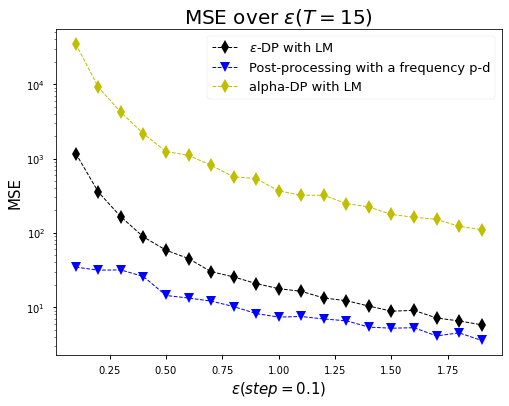

In [29]:
x_e = arange(0.1,2,step=0.1)
plt.figure(figsize = (8,6))
plt.semilogy(x_e,noisyMSE_e,linestyle = '--',marker = 'd',color = 'k',label = '$\epsilon$-DP with LM',linewidth = 1,markersize=10)
plt.semilogy(x_e,optimalMSE1_e,'bv--',label = 'Post-processing with a frequency p-d',linewidth = 1,markersize=10)
#plt.semilogy(x_e[:],optimalMSE1_uniform_e[:],'gv--',label = 'Post-processing with a uniform p-d',linewidth = 1,markersize=10)
#plt.semilogy(x[:],optimalMSE1_uniform[6:],'gv--',linewidth = 1,markersize=10)
#plt.semilogy(x,optimalMSE2,'rv--',label = 'Post-processing(drops temporal correlation)',linewidth = 1,markersize=10)
plt.semilogy(x_e,alpha_noisyMSE_e,linestyle = '--',marker = 'd',color = 'y',label = 'alpha-DP with LM',linewidth = 1,markersize=10)
plt.xlabel('$\epsilon (step = 0.1)$',fontsize=15)
plt.ylabel('MSE',fontsize=15)
plt.title(r'MSE over $\epsilon$($T=15$)',fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=13)
plt.savefig(r'fig(MSEoverEpsilon4).png',dpi = 600)
plt.show()

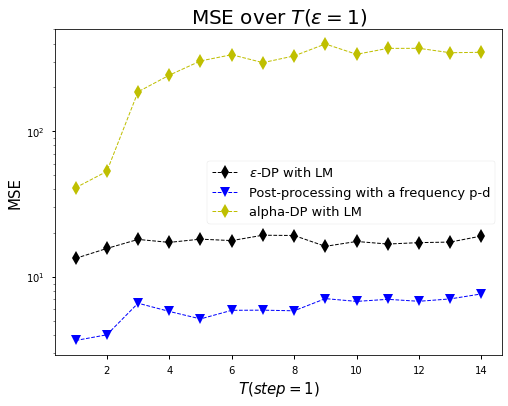

In [30]:
x_t = arange(1,15,step=1)
plt.figure(figsize = (8,6))
plt.semilogy(x_t,noisyMSE_t,linestyle = '--',marker = 'd',color = 'k',label = '$\epsilon$-DP with LM',linewidth = 1,markersize=10)
plt.semilogy(x_t,optimalMSE1_t,'bv--',label = 'Post-processing with a frequency p-d',linewidth = 1,markersize=10)
#plt.semilogy(x[:],optimalMSE1_uniform[:],'gv--',label = 'Post-processing with a uniform p-d',linewidth = 1,markersize=10)
#plt.semilogy(x[:],optimalMSE1_uniform[6:],'gv--',linewidth = 1,markersize=10)
#plt.semilogy(x,optimalMSE2,'rv--',label = 'Post-processing(drops temporal correlation)',linewidth = 1,markersize=10)
plt.semilogy(x_t,alpha_noisyMSE_t,linestyle = '--',marker = 'd',color = 'y',label = 'alpha-DP with LM',linewidth = 1,markersize=10)
plt.xlabel('$T (step = 1)$',fontsize=15)
plt.ylabel('MSE',fontsize=15)
plt.title(r'MSE over $T$($\epsilon=1$)',fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=13)
plt.savefig(r'fig(MSEoverT3).png',dpi = 600)
plt.show()


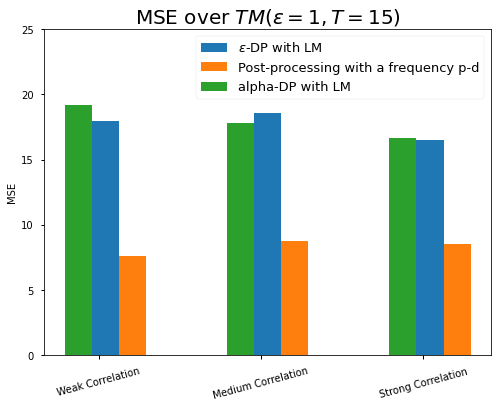

In [32]:
x = arange(3)
x_labels = ['Weak Correlation','Medium Correlation','Strong Correlation']
total_width, n = 0.5, 3
width = total_width/n
x1 = x-3*width/4
x2 = x1+width
x3 = x2+width
plt.figure(figsize = (8,6))
plt.bar(x2,noisyMSE,width=width,label = '$\epsilon$-DP with LM')
plt.bar(x3,optimalMSE1,width=width,label = 'Post-processing with a frequency p-d')
plt.bar(x1,alpha_noisyMSE,width=width,label = 'alpha-DP with LM')
plt.xticks(x,x_labels,rotation=15,fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(0,25.0)
plt.ylabel('MSE',fontsize=10)
plt.title(r'MSE over $TM$($\epsilon=1, T=15$)',fontsize=20)
plt.legend(fontsize=13)
plt.savefig(r'fig(MSEoverTM3).png',dpi = 520)
plt.show()
